# Entrenando un clasificador personalizado

Vamos a proceder a entrenar un clasificador preentrenado con imágenes de Imagenet para que sea capaz de detectar nuestras clases a partir de un dataset creado por nosotros

## Librerías

In [ ]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
!sudo apt-get install zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zip is already the newest version (3.0-11build1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


## Dataset

Procedemos a descargar nuestro dataset

In [ ]:
!wget https://mario-tf.s3.eu-west-3.amazonaws.com/Dataset.zip

--2021-02-07 12:26:51--  https://mario-tf.s3.eu-west-3.amazonaws.com/Dataset.zip
Resolving mario-tf.s3.eu-west-3.amazonaws.com (mario-tf.s3.eu-west-3.amazonaws.com)... 52.95.154.56
Connecting to mario-tf.s3.eu-west-3.amazonaws.com (mario-tf.s3.eu-west-3.amazonaws.com)|52.95.154.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1737176090 (1.6G) [application/zip]
Saving to: ‘Dataset.zip.1’

Dataset.zip.1       100%[===================>]   1.62G  36.9MB/s    in 46s     

2021-02-07 12:27:38 (36.1 MB/s) - ‘Dataset.zip.1’ saved [1737176090/1737176090]



In [ ]:
!unzip Dataset.zip -q

Archive:  Dataset.zip
caution: filename not matched:  -q


Fijamos los parámetros del tamaño de la imagen y del batch

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/Dataset',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 512 files belonging to 5 classes.
Using 410 files for training.


Vemos las 5 clases preestablecidas que coinciden con los movimientos del personaje

In [ ]:
class_names = np.array(train_ds.class_names)
print(class_names)

['back' 'back_jump' 'forward' 'forward_jump' 'jump']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


## Descargando el clasificador


En este caso vamos a descargar un modelo ligero [MobileNetV2 model](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) desde el Hub de Tensorflow. Cualquier [clasificador compatible de estos](https://tfhub.dev/s?q=tf2&module-type=image-classification) funcionaría.

In [ ]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


Añadimos las ultimas capas al modelo para que sea capaz de clasificar nuestras 5 clases

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
predictions = model(image_batch)

In [ ]:
predictions.shape

TensorShape([32, 5])

## Entrenamos el modelo

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [ ]:
!nvidia-smi

Sun Feb  7 12:28:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    53W /  70W |   2679MiB / 15079MiB |     20%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=20,
                    callbacks=[batch_stats_callback])

Epoch 1/20
13/13 [==============================] - 33s 803ms/step - loss: 1.8474 - acc: 0.2603
Epoch 2/20
13/13 [==============================] - 0s 36ms/step - loss: 1.5672 - acc: 0.3139
Epoch 3/20
13/13 [==============================] - 0s 37ms/step - loss: 1.4948 - acc: 0.3340
Epoch 4/20
13/13 [==============================] - 0s 37ms/step - loss: 1.4143 - acc: 0.4274
Epoch 5/20
13/13 [==============================] - 0s 37ms/step - loss: 1.3636 - acc: 0.4542
Epoch 6/20
13/13 [==============================] - 0s 37ms/step - loss: 1.3160 - acc: 0.4942
Epoch 7/20
13/13 [==============================] - 0s 36ms/step - loss: 1.2724 - acc: 0.5299
Epoch 8/20
13/13 [==============================] - 0s 37ms/step - loss: 1.2326 - acc: 0.5555
Epoch 9/20
13/13 [==============================] - 0s 37ms/step - loss: 1.1953 - acc: 0.5743
Epoch 10/20
13/13 [==============================] - 0s 37ms/step - loss: 1.1611 - acc: 0.5900
Epoch 11/20
13/13 [==============================] - 0s 3

Visualizamos el decremento del error

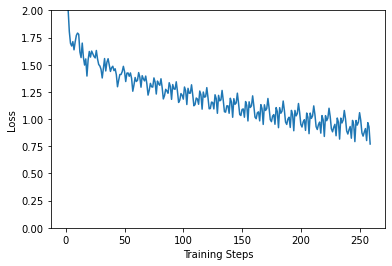

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

Y el incremento de la precisión a medida que pasan las epocas

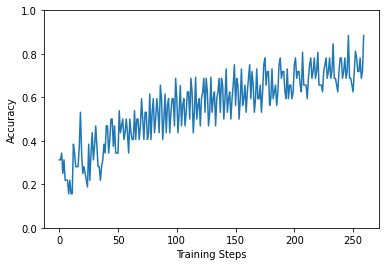

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

## Exportamos el modelo

In [ ]:
export_path = "/saved_models/gestures"
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /saved_models/gestures/assets


INFO:tensorflow:Assets written to: /saved_models/gestures/assets


'/saved_models/gestures'

## Confirmamos que podemos volver a cargarlo

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()

0.0

## Exportamos a TF.js

In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --signature_name=serving_default \
    --saved_model_tags=serve \
    /saved_models/gestures \
    /mobilenet/web_model

2021-02-07 12:32:16.374230: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-02-07 12:32:18.117373: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-07 12:32:18.118478: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-07 12:32:18.123415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-07 12:32:18.123989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2021-02-07 12:32:18.124052: I tensorflow/stream_executor/platform/default/dso_loade

*Machine Learning Engineering 2021*

*Lorenzo Rondán & Andrés Martinez*